<a href="https://colab.research.google.com/github/ossamum/google-meridian/blob/main/Google_Meridian_Simulated_Data_National.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importings

In [ ]:
# Install meridian: from PyPI @ latest release
!pip install --upgrade google-meridian[colab,and-cuda]

# Install meridian: from PyPI @ specific version
# !pip install google-meridian[colab,and-cuda]==1.1.1

# Install meridian: from GitHub @HEAD
# !pip install --upgrade "google-meridian[colab,and-cuda] @ git+https://github.com/google/meridian.git@main"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.6/234.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.0/888.0 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 115.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.23.4
    Uninstalling nvidia-nccl-cu12-2.23.4:
      Successfully uninstalled nvidia-nccl-cu12-2.23.4
  Attempting uninstall: natsort
    Found existing installation: natsort 8.4.0
    Uninstalling natsort-8.4.0:
      Successfully uninstalled natsort-8.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19

In [ ]:
import arviz as az
import IPython
from meridian import constants
from meridian.analysis import analyzer
from meridian.analysis import formatter
from meridian.analysis import optimizer
from meridian.analysis import summarizer
from meridian.analysis import visualizer
from meridian.data import data_frame_input_data_builder
from meridian.data import test_utils

from meridian.model import model
from meridian.model import prior_distribution
from meridian.model import spec
import numpy as np
import pandas as pd
# check if GPU is available
from psutil import virtual_memory
import tensorflow as tf
import tensorflow_probability as tfp

import seaborn as sns
import matplotlib.pyplot as plt

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print(
    'Num GPUs Available: ',
    len(tf.config.experimental.list_physical_devices('GPU')),
)
print(
    'Num CPUs Available: ',
    len(tf.config.experimental.list_physical_devices('CPU')),
)

Your runtime has 13.6 gigabytes of available RAM

Num GPUs Available:  1
Num CPUs Available:  1


In [ ]:
pd.options.display.max_columns = None

# Data loading and processing

In [ ]:
df = pd.read_csv('Simulated_Data_National.csv').drop(columns=['Unnamed: 0'])
df.shape

(156, 22)

In [ ]:
df.head(3)

,time,Channel0_impression,Channel1_impression,Channel2_impression,Channel3_impression,Channel4_impression,Channel5_impression,Channel0_spend,Channel1_spend,Channel2_spend,Channel3_spend,Channel4_spend,Channel5_spend,GQV,Geo_GDP,Competitor_Discount,conversions,revenue_per_conversion,Channel4_reach,Channel5_reach,Channel4_frequency,Channel5_frequency
0,2021-01-25,22196304.0,5712889.0,13918631.0,17072912.0,17343480.0,2767630.0,190494.19,56647.516,121492.20,132557.12,141236.69,21693.094,-0.529628,-24.884350,-2.655724,342742370.0,0.020010,8099505.0,1464881.0,2.141301,1.889321
1,2021-02-01,27658918.0,9929533.0,10223184.0,27668936.0,12784942.0,10120146.0,237375.72,98458.660,89235.58,214826.55,104114.22,79323.200,13.778649,-18.486712,-17.554234,363192200.0,0.019985,6920225.0,5017149.0,1.847475,2.017111
2,2021-02-08,45034828.0,13968472.0,29166668.0,44537184.0,30223412.0,11200601.0,386500.10,138507.720,254588.45,345794.66,246124.44,87791.970,30.576717,-38.086990,38.771027,415416400.0,0.020015,12528367.0,6002935.0,2.412398,1.865854


In [ ]:
df['time'].min(), df['time'].max()

('2021-01-25', '2024-01-15')

In [ ]:
# check if gaps in time
assert len(pd.date_range(df['time'].min(), df['time'].max(), freq='7D')) == df['time'].shape[0]

In [ ]:
# check if any null values
assert df.isna().sum().any() == False

# Exploratory Data Analysis (EDA)

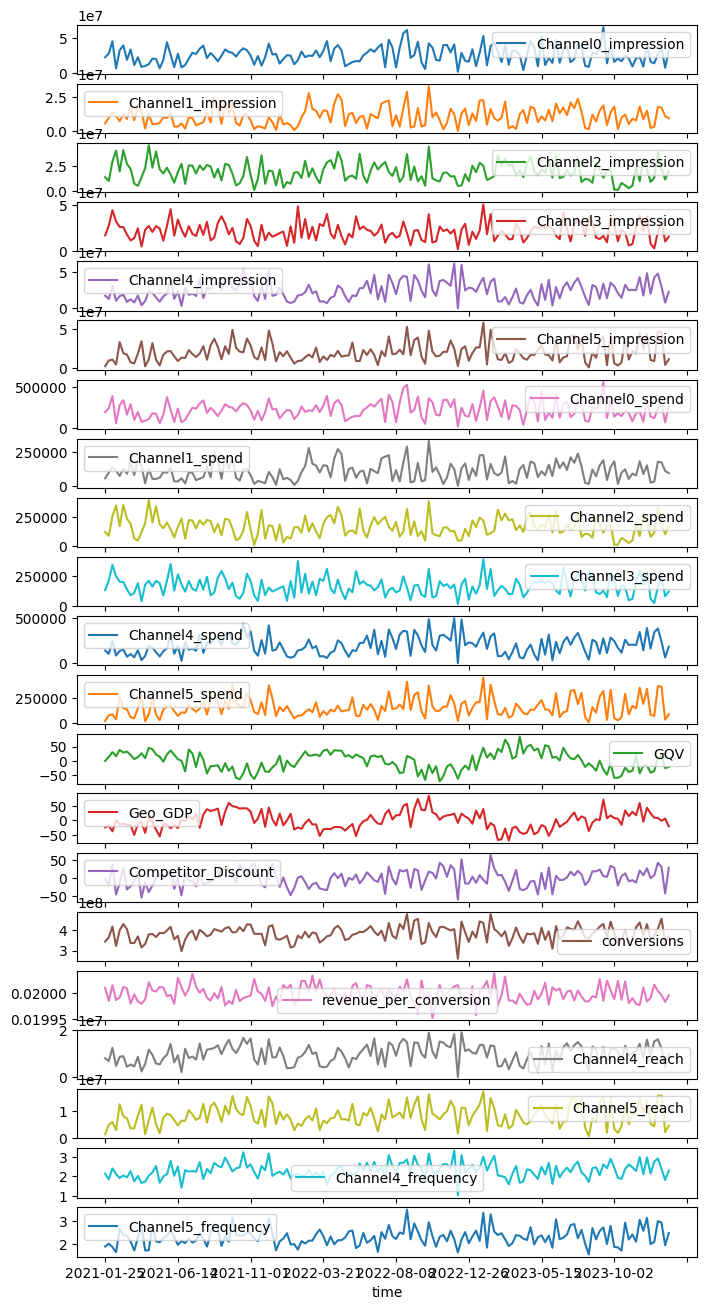

In [ ]:
df.set_index('time').plot(subplots=True, figsize=(8, 16));

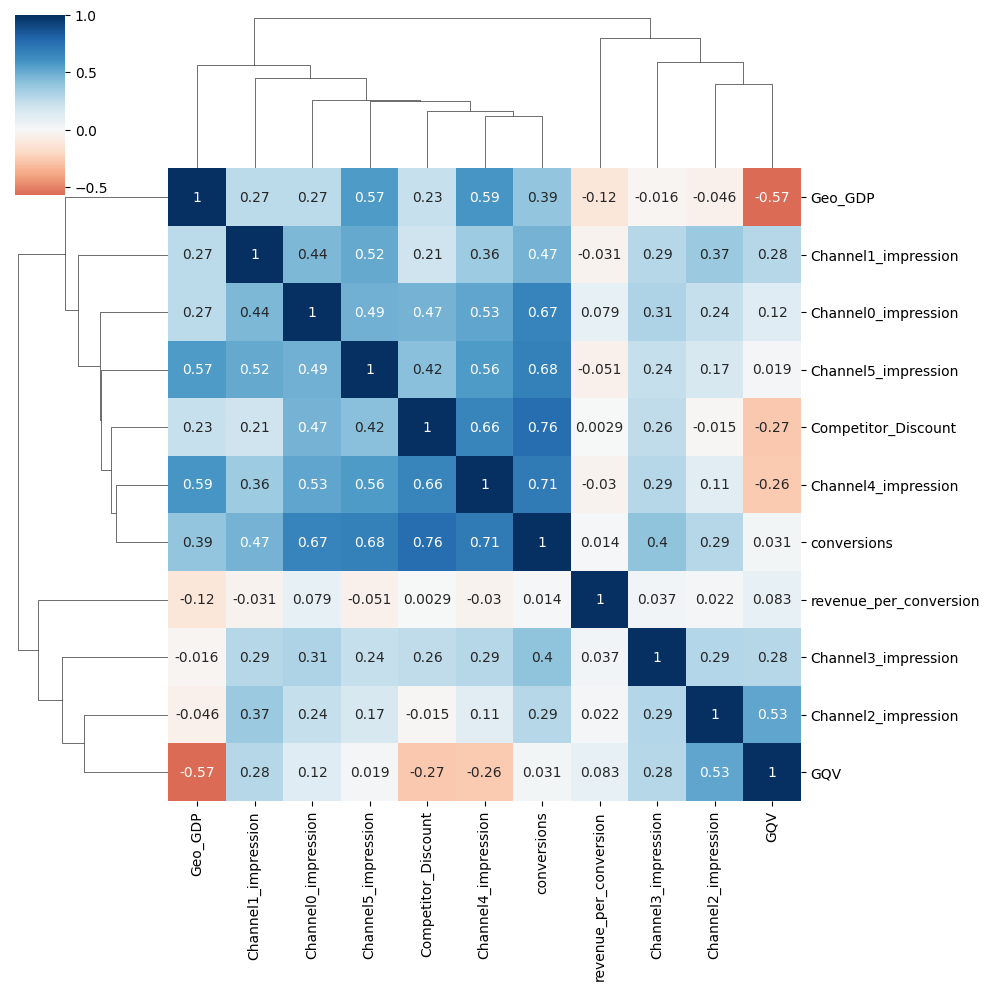

In [ ]:
sns.clustermap(df[[
  'Channel0_impression',
  'Channel1_impression',
  'Channel2_impression',
  'Channel3_impression',
  'Channel4_impression',
  'Channel5_impression',
  'GQV',
  'Geo_GDP',
  'Competitor_Discount',
  'conversions',
  'revenue_per_conversion',
]].corr(), annot=True, cmap='RdBu', center=0);

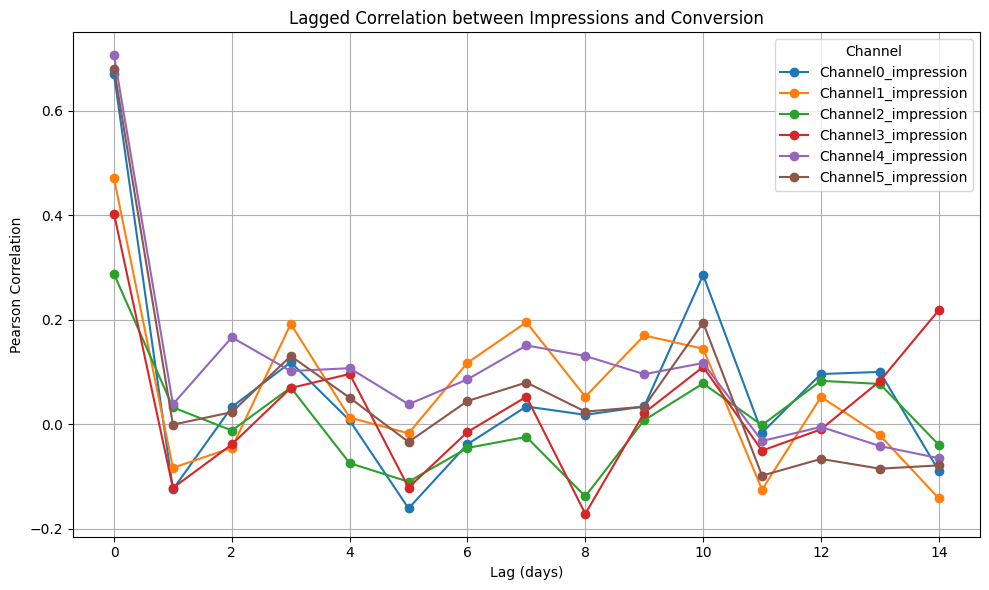

In [ ]:
# List of channel impression variables
channel_cols = [
    'Channel0_impression',
    'Channel1_impression',
    'Channel2_impression',
    'Channel3_impression',
    'Channel4_impression',
    'Channel5_impression'
]

# Target variable
target = 'conversions'

# Max lag to test
max_lag = 14

# Dictionary to store correlations
correlation_results = {col: [] for col in channel_cols}

# Compute correlations for each lag
for lag in range(0, max_lag + 1):
    for col in channel_cols:
        # Shift the impression data forward by lag days
        shifted = df[col].shift(lag)
        corr = df[target].corr(shifted)
        correlation_results[col].append(corr)

# Convert results to a DataFrame
corr_df = pd.DataFrame(correlation_results, index=range(0, max_lag + 1))
corr_df.index.name = 'Lag'

# Plot the lagged correlations
corr_df.plot(figsize=(10, 6), marker='o')
plt.title('Lagged Correlation between Impressions and Conversion')
plt.xlabel('Lag (days)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.legend(title='Channel')
plt.tight_layout()
plt.show()


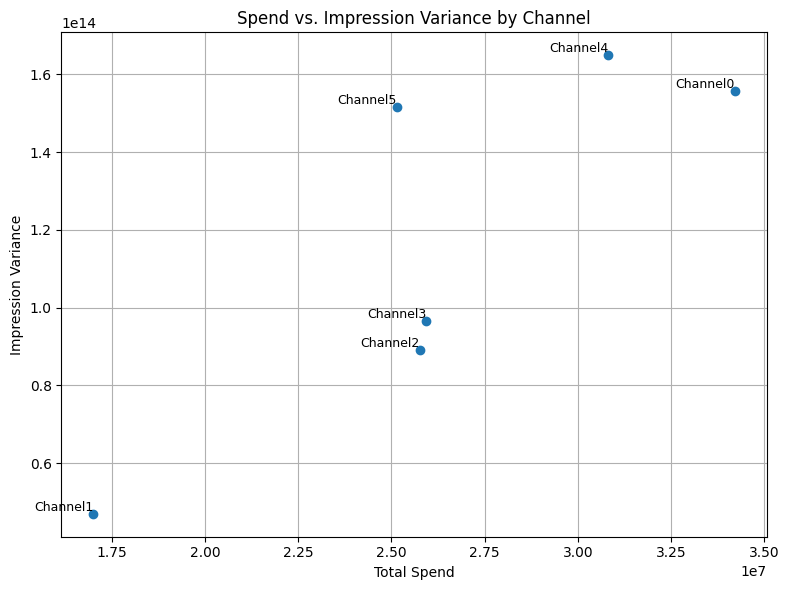

In [ ]:
# Calculate x and y values
x_values = df.iloc[:, df.columns.str.contains('spend')].sum().tolist()
y_values = df.iloc[:, df.columns.str.contains('impression')].var().tolist()

# Generate labels
labels = [f'Channel{i}' for i in range(len(x_values))]

# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values, y_values)

# Add text labels near each point
for i, label in enumerate(labels):
    plt.text(x_values[i], y_values[i], label, fontsize=9, ha='right', va='bottom')

plt.xlabel("Total Spend")
plt.ylabel("Impression Variance")
plt.title("Spend vs. Impression Variance by Channel")
plt.grid(True)
plt.tight_layout()
plt.show()


# Model Specification

In [ ]:
df.columns.tolist()

['time',
 'Channel0_impression',
 'Channel1_impression',
 'Channel2_impression',
 'Channel3_impression',
 'Channel4_impression',
 'Channel5_impression',
 'Channel0_spend',
 'Channel1_spend',
 'Channel2_spend',
 'Channel3_spend',
 'Channel4_spend',
 'Channel5_spend',
 'GQV',
 'Geo_GDP',
 'Competitor_Discount',
 'conversions',
 'revenue_per_conversion',
 'Channel4_reach',
 'Channel5_reach',
 'Channel4_frequency',
 'Channel5_frequency']

In [ ]:
channels = ["Channel0", "Channel1", "Channel2", "Channel3"]

In [ ]:
builder = data_frame_input_data_builder.DataFrameInputDataBuilder(
    kpi_type='non_revenue',
    default_kpi_column='conversions',
    default_revenue_per_kpi_column='revenue_per_conversion',
)

In [ ]:
builder = (
    builder.with_kpi(df)
    .with_revenue_per_kpi(df)
    .with_controls(
        df,
        control_cols=[
            'Geo_GDP',
            'Competitor_Discount',
            'GQV',
        ],
    )
    .with_media(
        df,
        media_cols=[f"{channel}_impression" for channel in channels],
        media_spend_cols=[f"{channel}_spend" for channel in channels],
        media_channels=channels,
      )
    .with_reach(
        df,
        reach_cols=["Channel4_reach", "Channel5_reach"],
        frequency_cols=["Channel4_frequency", "Channel5_frequency"],
        rf_spend_cols=["Channel4_spend", "Channel5_spend"],
        rf_channels=["Channel4", "Channel5"],
    )
)

In [ ]:
data = builder.build()

In [ ]:
roi_mu = 0.2  # Mu for ROI prior for each media channel.
roi_sigma = 0.9  # Sigma for ROI prior for each media channel.
prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M)
)
model_spec = spec.ModelSpec(prior=prior)

mmm = model.Meridian(input_data=data, model_spec=model_spec)

/usr/local/lib/python3.11/dist-packages/meridian/model/model.py:66: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(


In [ ]:
%%time
mmm.sample_prior(500)
mmm.sample_posterior(
    n_chains=10, n_adapt=2000, n_burnin=500, n_keep=1000, seed=0
)

/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_om has been automatically set to

CPU times: user 6min 56s, sys: 16.8 s, total: 7min 12s
Wall time: 7min 14s


# Model Diagnostics

In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

In [ ]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:590: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


alt.LayerChart(...)

# Model Output

In [ ]:
mmm_summarizer = summarizer.Summarizer(mmm)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filepath = '/content/drive/MyDrive'
mmm_summarizer.output_model_results_summary(
    'summary_output.html', filepath, df['time'].min(), df['time'].max()
)

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:3103: UserWarning: Effectiveness is not reported because it does not have a clear interpretation by time period.
  warnings.warn(


In [ ]:
IPython.display.HTML(filename=f'{filepath}/summary_output.html')

Dataset,R-squared,MAPE,wMAPE
All Data,0.85,3%,3%


# Optimization

In [ ]:
%%time
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


CPU times: user 29.9 s, sys: 1.53 s, total: 31.4 s
Wall time: 36.5 s


In [ ]:
optimization_results.output_optimization_summary(
    'optimization_output.html', filepath
)

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [ ]:
IPython.display.HTML(filename=f'{filepath}/optimization_output.html')

Channel,Non-optimized spend,Optimized spend
Channel0,22%,26%
Channel5,16%,21%
Channel4,19%,16%
Channel2,16%,16%
Channel3,16%,14%
Channel1,11%,7%
